# Conv GAN

In [11]:
# following https://mafda.medium.com/gans-deep-convolutional-gans-with-cifar10-part-8-be881a77e55b
# with minor modifications
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [12]:
num_classes = 10

In [13]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

In [14]:
print(train_features.shape)

(50000, 32, 32, 3)


In [15]:
x_train = (train_features.astype('float32')/255 - 0.5) * 2
x_train = np.clip(x_train, -1, 1)

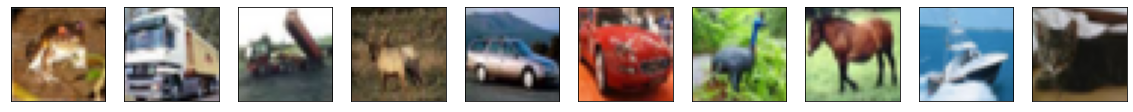

In [16]:
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_features[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Build Model

In [17]:
init = initializers.RandomNormal(stddev=0.02)

def build_discriminator():
       # imagem shape 32x32x3
    img_shape = x_train[0].shape

    # Discriminator network
    discriminator = keras.Sequential()

    # Conv 1: 16x16x64
    discriminator.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                             input_shape=(img_shape), kernel_initializer=init))
    discriminator.add(layers.LeakyReLU(0.2))

    # Conv 2:
    discriminator.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))

    # Conv 3:
    discriminator.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))

    # Conv 3:
    discriminator.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))

    # FC
    discriminator.add(layers.Flatten())

    # Output
    discriminator.add(layers.Dense(1, activation='sigmoid'))
    return discriminator

In [18]:
latent_dim = 100

def build_generator():
    
    # Generator network
    generator = keras.Sequential()

    # FC: 2x2x512
    generator.add(layers.Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
    generator.add(layers.Reshape((2, 2, 512)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    # # Conv 1: 4x4x256
    generator.add(layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    # Conv 2: 8x8x128
    generator.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    # Conv 3: 16x16x64
    generator.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU(0.2))

    # Conv 4: 32x32x3
    generator.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                                  activation='tanh'))
    return generator
    

In [19]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = keras.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = keras.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy',   optimizer='adam')
    return gan

In [20]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',   optimizer='adam')
generator = build_generator()
gan = build_gan(generator, discriminator)

In [21]:
def plot_generated_images(epoch, generator):
    num_of_images = 100
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')

## Train Model

In [22]:
def train_model(epochs, batch_size):
    num_batches = x_train.shape[0]//batch_size
    for ep in range(epochs):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            generated_images = generator.predict(noise)
            X = np.concatenate([generated_images, image_batch])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 1.0   
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)
            


In [ ]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)